### Imports

In [1]:
import sys
sys.path.append("/nfs/home/rhotertj/Code/thesis/")
import numpy as np
import pandas as pd
import pickle as pkl
import ipywidgets as widgets
from collections import Counter, defaultdict
import os.path as osp
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from src.data import HandballSyncedDataset
from src.utils import array2gif, draw_trajectory

### Checking frequencies of labels across matches

In [ ]:
dataset = HandballSyncedDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta.csv",
    seq_len=12,
    sampling_rate=2,
    load_frames=False   
)
ctr = Counter()
no_action = 0
print("Dataset size:", len(dataset))

In [ ]:
for idx, instance in tqdm(enumerate(dataset), total=len(dataset)):
    label = instance["label"]
    if isinstance(label, dict):
        ctr.update({f"{label['Pass']}{label['Wurf']}" : 1})
    else:
        no_action += 1

class_combinations = pd.DataFrame()
for (pass_cls, shot_cls), n in ctr.items():
    class_combinations.loc[shot_cls, pass_cls] = n
print("No action:", no_action)
class_combinations

In [ ]:
class_combinations.sum().sum() + no_action == len(dataset)

In [ ]:
class_combinations.to_csv("occurences_12_2.csv")

In [ ]:
from collections import defaultdict
import pickle as pkl
class2frame = defaultdict(list)
valid_combs = ['A0', 'A1', 'B0', 'O0', 'C0', 'D0', 'X0', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8']

for events in tqdm(dataset.event_dfs):
    events["Wurf"] = events.labels.apply(lambda x : x["Wurf"])
    events["Pass"] = events.labels.apply(lambda x : x["Pass"])
    for k in valid_combs:
        p, w = k
        f = events[(events["Pass"] == p) & (events["Wurf"] == w)].index.tolist()
        if f:
            class2frame[k].append(f)

with open("class2frame.pkl", "wb+") as f:
    pkl.dump(class2frame, f)


### Plotting positions and frames for synchronisation

In [ ]:
sql = 12
sr = 2
dataset_img = HandballSyncedDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=True   
)
# [(k, v) for (k,v) in dataset_img.event_dfs[0].head(20)["labels"].items()]
# 12126 O0
print("Match boundaries:", dataset_img.index_tracker)

In [ ]:
idx = 109340
pos_offset = 0 # positive values move positions "into the past"
example = dataset_img.__getitem__(idx) #, frame_idx=idx, match_number=0)

frames = np.transpose(example["frames"], (3, 0, 1, 2))
positions = example["positions"]

print("Frames and positions shape:", frames.shape, positions.shape)
print("Action label frame number:", example["label_offset"])
print("Label:", example["label"])

array2gif(frames, f"../img/instance_{idx}_{sql}x{sr}.gif", fps=10)
fig = draw_trajectory(positions)
# Mismatch Notes:
# Game | positions offset
# 0s   | 8 frames in the future
# 1s   | 20 frames in the future, 109340 32x1
# 2s   | mirrored, 16 frames in the past 204000 32x1
# 3s   | looks good (319120 32x1 data)
# 4s   | 16 frames in the future, see 426000 32x1
# 5s   | mirrored, ok see 533450 32x1
# 6s   | mirrored, ok, 641300 31x1
# 7s   | 5 frames in the future, 745700 32x1
# 8s   | mirrored, 47 frames in the future 854000 32x1
# 9s   | 16 frames in the future 962400 32x1
# 10s  | mirrored, 8 in the future 1071800

In [6]:
offsets = np.array([
    8,
    20,
    -8,
    0,
    16,
    0,
    0,
    5,
    47,
    16,
    16
])

p = "/nfs/home/rhotertj/datasets/hbl/meta.csv"
df = pd.read_csv(p)
for i, _ in df.iterrows():
    df.loc[i, "position_offset"] = offsets[i]

df.to_csv(p)
df

,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,match_id,raw_pos_knx,raw_video,...,v_h2_end,p_h1,p_h2,duration,avg_frame_rate,n_frames,frames_path,events_path,positions_path,position_offset
0,0,0,0,0,0,0,0,sr:sport_event:18639810,Game 74.csv,2019-09-03_631765_hsg_wetzlar-sg_flensburg-han...,...,6318.766667,-58.500000,-58.500000,6463.997331,29.97,193726.0,/nfs/home/rhotertj/datasets/hbl/frames/48dcd3_...,/nfs/home/rhotertj/datasets/hbl/events/1863981...,/nfs/home/rhotertj/datasets/hbl/positions/1863...,8.0
1,1,1,1,1,1,1,1,sr:sport_event:18639812,Game 73.csv,2019-09-03_631771_sc_dhfk_leipzig-tvb_1898_stu...,...,6020.800000,186.000000,186.000000,6299.799800,29.97,188805.0,/nfs/home/rhotertj/datasets/hbl/frames/7e8637_...,/nfs/home/rhotertj/datasets/hbl/events/1863981...,/nfs/home/rhotertj/datasets/hbl/positions/1863...,20.0
2,2,2,2,2,2,2,2,sr:sport_event:18949256,Game 2.csv,2019-09-15_631788_sc_dhfk_leipzig-frisch_auf_g...,...,7191.666667,613.333333,613.333333,8399.833166,29.97,251743.0,/nfs/home/rhotertj/datasets/hbl/frames/36d354_...,/nfs/home/rhotertj/datasets/hbl/events/1894925...,/nfs/home/rhotertj/datasets/hbl/positions/1894...,-8.0
3,3,3,3,3,3,3,3,sr:sport_event:18949260,Game 4.csv,2019-09-19_631791_bergischer_hc-thw_kiel-720p-...,...,4720.566667,-330.333333,-1242.833333,4738.071405,29.97,142000.0,/nfs/home/rhotertj/datasets/hbl/frames/20b85a_...,/nfs/home/rhotertj/datasets/hbl/events/1894926...,/nfs/home/rhotertj/datasets/hbl/positions/1894...,0.0
4,4,4,4,4,4,4,4,sr:sport_event:18949278,Game 9.csv,2019-09-26_631800_hsg_wetzlar-sc_magdeburg-720...,...,6657.433333,-396.000000,-396.000000,6899.099099,29.97,206766.0,/nfs/home/rhotertj/datasets/hbl/frames/f3d08a_...,/nfs/home/rhotertj/datasets/hbl/events/1894927...,/nfs/home/rhotertj/datasets/hbl/positions/1894...,16.0
5,5,5,5,5,5,5,5,sr:sport_event:18949280,Game 6.csv,2019-09-26_631801_tsv_hannover-burgdorf-sg_fle...,...,6088.666667,-352.000000,-352.000000,6181.147814,29.97,185249.0,/nfs/home/rhotertj/datasets/hbl/frames/10bbe2_...,/nfs/home/rhotertj/datasets/hbl/events/1894928...,/nfs/home/rhotertj/datasets/hbl/positions/1894...,0.0
6,6,6,6,6,6,6,6,sr:sport_event:18949282,Game 17.csv,2019-09-26_631802_sc_dhfk_leipzig-bergischer_h...,...,6366.833333,-237.500000,-237.500000,6442.709376,29.97,193088.0,/nfs/home/rhotertj/datasets/hbl/frames/123b93_...,/nfs/home/rhotertj/datasets/hbl/events/1894928...,/nfs/home/rhotertj/datasets/hbl/positions/1894...,0.0
7,7,7,7,7,7,7,7,sr:sport_event:18639730,Game 62.csv,2019-08-22_628843_hsg_wetzlar-tbv_lemgo_lippe-...,...,4749.500000,-354.500000,-1261.333333,4755.989323,29.97,142537.0,/nfs/home/rhotertj/datasets/hbl/frames/916c51_...,/nfs/home/rhotertj/datasets/hbl/events/1863973...,/nfs/home/rhotertj/datasets/hbl/positions/1863...,5.0
8,8,8,8,8,8,8,8,sr:sport_event:18639836,Game 76.csv,2019-09-08_631778_tbv_lemgo_lippe-tsv_hannover...,...,6941.166667,1182.666667,1182.666667,7286.820153,29.97,218386.0,/nfs/home/rhotertj/datasets/hbl/frames/6396c7_...,/nfs/home/rhotertj/datasets/hbl/events/1863983...,/nfs/home/rhotertj/datasets/hbl/positions/1863...,47.0
9,9,9,9,9,9,9,9,sr:sport_event:18639808,Game 78.csv,2019-09-04_631764_rhein-neckar_loewen-bergisch...,...,5650.966667,83.833333,83.833333,5786.686687,29.97,173427.0,/nfs/home/rhotertj/datasets/hbl/frames/97bba8_...,/nfs/home/rhotertj/datasets/hbl/events/1863980...,/nfs/home/rhotertj/datasets/hbl/positions/1863...,16.0


### Debugging idx -> Frame index mapping

In [ ]:
sql = 4
hql = sql // 2
rate = 2
sr = sql * rate
hr = hql * rate
kernel = np.ones(sr)

availables = [False, False, True, True, True, True, True, True, True, True, True, True, True, False, False]
pos = np.arange(len(availables))

cv = np.convolve(availables, kernel)
print(f"{cv}")
idxs = np.where(cv == sr)[0] - (sr - 1)
print("idx for valid sequences:", idxs)

q_idx = 0
f_idx = idxs[q_idx] + hr
sequence = pos[f_idx - hr : f_idx + hr : rate]
print(f"Idx for sequence {q_idx}: {sequence}")

### Visualizing each class

In [7]:
sql = 12
sr = 2
dataset_img = HandballSyncedDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=True
)

with open("class2frame.pkl", "rb") as f:
    class2frame = pkl.load(f)

Read /nfs/home/rhotertj/datasets/hbl/meta.csv...


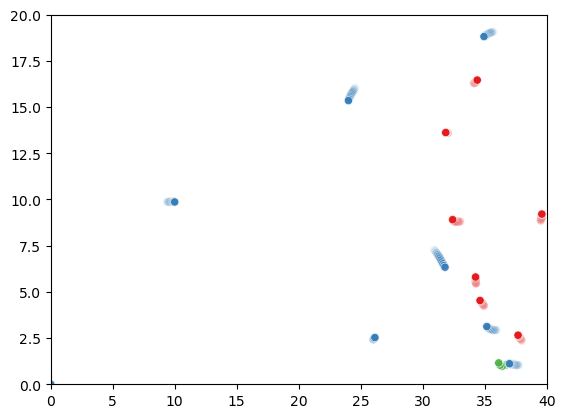

In [8]:
n_per_class = 3
for cls, frame_lists in class2frame.items():
    match_id = 0
    frame_id = 0
    n = 0
    for i, fl in enumerate(frame_lists):
        if n == n_per_class:
            break
        if fl:
            match_id = i
            try:
                frame_id = fl[(len(fl) // 2) + n] # dont take first pass of the game
            except:
                continue
            example = dataset_img.__getitem__(0, frame_idx=frame_id, match_number=match_id)
            frames = np.transpose(example["frames"], (3, 0, 1, 2))
            gifname = f"../img/class_{cls}_{n}_{match_id}x{frame_id}.gif"
            array2gif(frames, gifname, fps=10)

            positions = example["positions"]
            fig = draw_trajectory(positions)
            figname = f"../img/class_{cls}_{n}_{match_id}x{frame_id}.png"
            fig.savefig(figname)
            print(figname)
            print(gifname)

            n+= 1
            